In [19]:
import numpy as np

def generate_rotating_wedge_stimulus(n_frames=300,
                                     height=200,
                                     width=200,
                                     visual_field_deg=16.08,
                                     wedge_width_deg=90,
                                     cycle_duration=32,
                                     n_cycles=8,
                                     blank_duration=22,
                                     direction='ccw'):
    """
    Generates a binary stimulus matrix representing a rotating wedge stimulus.

    Parameters:
    - n_frames: total number of frames (TRs), default 300
    - height, width: spatial resolution in pixels
    - visual_field_deg: total size of visual field in degrees (assumed square)
    - wedge_width_deg: angular width of the rotating wedge
    - cycle_duration: seconds per full 360° rotation (1 cycle)
    - n_cycles: number of full cycles
    - blank_duration: seconds of blank at start and end
    - direction: 'ccw' or 'cw' (counterclockwise or clockwise)

    Returns:
    - stimulus: array of shape (n_frames, height, width) with binary apertures
    """
    # Visual field coordinate grid in degrees
    x = np.linspace(-visual_field_deg / 2, visual_field_deg / 2, width)
    y = np.linspace(-visual_field_deg / 2, visual_field_deg / 2, height)
    xv, yv = np.meshgrid(x, y)
    polar_angle = (np.arctan2(yv, xv) * 180 / np.pi) % 360  # 0 to 360

    # TRs
    tr = 1.0
    frames_per_cycle = int(cycle_duration / tr)
    blank_frames = int(blank_duration / tr)
    stimulus = np.zeros((n_frames, height, width))

    # Fill in the rotating wedge frames
    for t in range(blank_frames, n_frames - blank_frames):
        cycle_pos = (t - blank_frames) % frames_per_cycle
        angle = (360 * cycle_pos / frames_per_cycle) % 360
        if direction == 'cw':
            angle = (360 - angle) % 360  # reverse rotation

        angle_diff = (polar_angle - angle + 180) % 360 - 180
        wedge_mask = (np.abs(angle_diff) <= wedge_width_deg / 2)
        stimulus[t][wedge_mask] = 1.0

    return stimulus

# Example usage
stimulus_matrix = generate_rotating_wedge_stimulus()
print(stimulus_matrix.shape)  

(300, 200, 200)


In [5]:
def make_prf_matrix(x0_pix, y0_pix, sigma_pix, height=200, width=200):
    """
    Generate a 2D Gaussian pRF matrix over a 200x200 grid (pixel units).
    
    Parameters:
    - x0_pix, y0_pix: center of the pRF in pixels (0-199)
    - sigma_pix: standard deviation of the Gaussian in pixels
    - height, width: grid size (default 200x200)
    
    Returns:
    - prf: 2D array of shape (height, width)
    """
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xv, yv = np.meshgrid(x, y)

    prf = np.exp(-((xv - x0_pix)**2 + (yv - y0_pix)**2) / (2 * sigma_pix**2))
    return prf

In [6]:
%pip install nilearn
import nibabel as nib
fmri_file = "./hcp_retino/HCP7T_retino/tfMRI_RETCCW_7T_AP.dtseries.nii"

# Load the file
img = nib.load(fmri_file)
data = img.get_fdata()

print("Shape of fMRI data:", data.shape)

Note: you may need to restart the kernel to use updated packages.
Shape of fMRI data: (300, 91282)


In [7]:
def simulate_voxel_response(stimulus, prf):
    """
    Simulate a voxel's neural response over time by multiplying the stimulus with a pRF.

    Parameters:
    - stimulus: 3D array of shape (T, H, W), where T = timepoints (TRs)
    - prf: 2D array of shape (H, W), the pRF matrix

    Returns:
    - response: 1D array of shape (T,), predicted neural response over time
    """
    # Dot product over (H, W) for each timepoint
    response = np.tensordot(stimulus, prf, axes=([1, 2], [0, 1]))
    return response

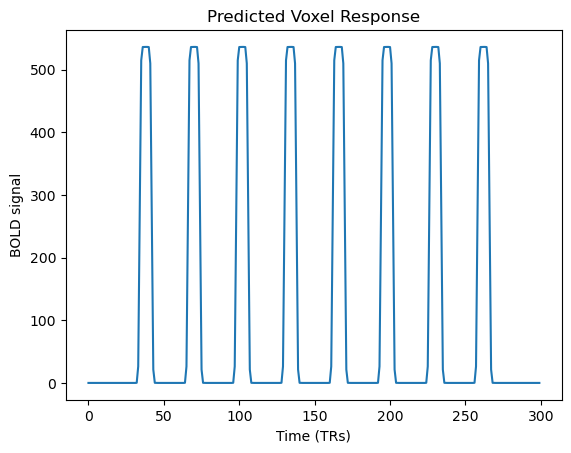

In [ ]:
# Example of simulating a voxel response
prf = make_prf_matrix(x0_pix=10, y0_pix=100, sigma_pix=10)
stimulus_matrix=generate_rotating_wedge_stimulus(n_frames=300, height=200, width=200, visual_field_deg=16.08, wedge_width_deg=90, cycle_duration=32, n_cycles=8, blank_duration=22, direction='ccw')
predicted_response = simulate_voxel_response(stimulus_matrix, prf)
import matplotlib.pyplot as plt
plt.plot(predicted_response)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD signal")
plt.title("Predicted Voxel Response")
plt.show()

In [31]:
from nilearn.glm.first_level import spm_hrf
from scipy.signal import convolve
# HRF (canonical, TR=1s)
hrf = spm_hrf(tr=1.0)

# Subset left hemisphere voxels (first 32492)
left_hemisphere_data = data[:, :5]
# Search grid
x_grid = np.linspace(0, 199, 30)
y_grid = np.linspace(0, 199, 30)
sigma_grid = np.linspace(1, 3, 10)

# Storage
best_params = np.zeros((left_hemisphere_data.shape[1], 3))  # x0, y0, sigma
best_r2 = np.zeros(left_hemisphere_data.shape[1])

# Fit per voxel
for voxel_idx in range(left_hemisphere_data.shape[1]):
    bold_ts = left_hemisphere_data[:, voxel_idx]
    bold_ts = (bold_ts - np.mean(bold_ts)) / np.std(bold_ts)  # optional normalization

    best_score = np.inf  # for MSE
    best_rsq = -np.inf
    
    for x0 in x_grid:
        for y0 in y_grid:
            for sigma in sigma_grid:
                prf = make_prf_matrix(x0, y0, sigma)
                neural_response = simulate_voxel_response(stimulus_matrix, prf)
                bold_pred = convolve(neural_response, hrf)[:stimulus_matrix.shape[0]]

                # Optional z-score BOLD
                bold_pred = (bold_pred - np.mean(bold_pred)) / np.std(bold_pred)

                mse = np.mean((bold_ts - bold_pred) ** 2)
                
                # Convert MSE to R²
                ss_res = np.sum((bold_ts - bold_pred) ** 2)
                ss_tot = np.sum((bold_ts - np.mean(bold_ts)) ** 2)
                r2 = 1 - ss_res / ss_tot

                if mse < best_score:
                    best_score = mse
                    best_rsq = r2
                    best_params[voxel_idx] = [x0, y0, sigma]
    
    best_r2[voxel_idx] = best_rsq

print("Done.")
print(best_params)

/var/folders/6j/4dfmtv_12fj9q312qyh1c7600000gn/T/ipykernel_43135/4224385479.py:4: DeprecationWarning: The parameter "tr" will be removed in 0.13.0 release of Nilearn. Please use the parameter "t_r" instead.
  hrf = spm_hrf(tr=1.0)


Done.
[[157.82758621  27.44827586   1.        ]
 [157.82758621  27.44827586   1.        ]
 [178.4137931    0.           1.66666667]
 [157.82758621  27.44827586   1.        ]
 [171.55172414 157.82758621   1.        ]]
